# Approches hybrides : réseaux de neurones

Pierrick DOSSIN  
Guillaume RIU 

In [1]:
!pip install tfds-nightly
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets==4.3
!pip install -q scann

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 109.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [2]:
import os
import pprint
import tempfile

from tqdm import tqdm
from typing import Dict, Text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
#import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

#### Charger les données

In [3]:
# Chargement des données
movie_path = 'Data/items.csv'
user_path  = 'Data/u.csv'
votes_path = 'Data/votes.csv'

movie_feat = pd.read_csv(movie_path)
user_feat  = pd.read_csv(user_path)
votes_df   = pd.read_csv(votes_path)
votes_df   = votes_df.astype('float32')
votes_df   = votes_df.rename(columns={'user.id': 'user_id', 'item.id': 'movie_id', 'rating': 'user_rating', 'timestamp': 'timestamp'})

In [4]:
# Convertir le dataframe en un tf dataset
votes_tf  = tf.data.Dataset.from_tensor_slices(tf.cast(votes_df.values, tf.float32))

In [36]:
# summarize history for loss
def plot_history(history, model_name="Two Towers"):
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title(model_name + ' Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
    print("\n\nErreur MSE méthode Two Tower : {0:.4f}".format(min(history.history['val_mean_squared_error'])))
    print("Erreur MAE methode Two Tower : {0:.4f}".format(history.history['val_mean_absolute_error'][np.argmin(history.history['val_mean_squared_error'])]))

In [6]:
# Extraire les attributs pour entrainer le modèle
votes = votes_tf.map(lambda x: {"user_id": tf.strings.as_string(x[0]), "movie_id": tf.strings.as_string(x[1]), "user_rating": x[2]})

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
#Titres des films
titres_films    = votes.map(lambda x: x["movie_id"]).batch(1000000)# On prend tous les films d'un coup
films_unique    = np.unique(np.concatenate(list(titres_films)))
nb_films_unique = films_unique.shape[0]
nb_films_unique

1682

In [8]:
#Identifiant des utilisateurs
id_utilisateurs = votes.map(lambda x: x["user_id"]).batch(1000000)# On prend tous les utilisateurs d'un coup
id_uniques      = np.unique(np.concatenate(list(id_utilisateurs)))
nb_id_uniques   = id_uniques.shape[0]
nb_id_uniques

943

### Initialisation des métriques MSE et MAE

In [26]:
task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(), 
    metrics = [tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [11]:
# Définition des couches de plongement pour les utilisateurs et les films
def initialisation_embeddings(embedding_dimension, id_uniques, films_unique):
    user_model = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=id_uniques, mask_token=None),
                                    tf.keras.layers.Embedding(len(id_uniques) + 1,# Le +1 représente la constante $c$
                                                                embedding_dimension)], name="User_Embedding")

    movie_model = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=films_unique,mask_token=None),
                                    tf.keras.layers.Embedding(len(films_unique) + 1, 
                                                                embedding_dimension)], name="Movie_Embedding")  
    return user_model, movie_model

#### Définir les bases de données d'entrainement et de validation (proportion $80\%-20\%$).

In [35]:
N          = len(votes)
batch_size = 8192 #2^13
prop       = 0.8
embedding_dimension = 64
train_len  = tf.cast(N * prop, dtype=tf.int64)
valid_len   = tf.cast(N - train_len, dtype=tf.int64)


tf.random.set_seed(73)
train = votes.take(train_len).shuffle(train_len, seed=73, reshuffle_each_iteration=False).batch(batch_size)
valid = votes.skip(train_len).take(valid_len).shuffle(valid_len, seed=73, reshuffle_each_iteration=False).batch(batch_size)

In [13]:
# On tire un exemple pour construire le graphe du modèle
feature = next(iter(train))
feature

{'user_id': <tf.Tensor: shape=(8192,), dtype=string, numpy=
 array([b'459.000000', b'206.000000', b'92.000000', ..., b'653.000000',
        b'210.000000', b'345.000000'], dtype=object)>,
 'movie_id': <tf.Tensor: shape=(8192,), dtype=string, numpy=
 array([b'879.000000', b'882.000000', b'475.000000', ..., b'403.000000',
        b'451.000000', b'518.000000'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(8192,), dtype=float32, numpy=array([4., 1., 5., ..., 2., 3., 4.], dtype=float32)>}

## Approche Two Tower
Nous allons définir et entrainer le modèle *Two Tower* afin de prédire les votes selon cette formule :

$$pred_{i,j}= \sigma(b + biais_{u_i} + biais_{f_j} +E_{u_i}^TE_{f_j}) \times (M_{vote} - m_{vote}) + m_{vote} $$
<br>

Où $(E_{u_i}, E_{f_j}) \in \mathbb{R}^n \times \mathbb{R}^n$ sont respectivement les plongements (<i>embeddings</i>) de l'utilisateur $i$, $u_i$, et du film $j$, $f_j$.

$b \in \mathbb{R}$ est la constante qui représente la moyenne. 

$n \in \mathbb{N}$ est la dimension de l'espace latent des utilisateurs et des films.


$biais_{u_i} \in \mathbb{R}$ est le biais associé à l'utilisateur $u_i$ et $biais_{f_j} \in \mathbb{R}$ le biais associé au film $f_j$. 

$\sigma: x \mapsto \cfrac{1}{1+e^{-x}}$ est la fonction sigmoid.

Et, $M_{vote}, m_{vote}$ sont respectivement le maximum et le minimum des votes utilisateurs. Dans notre cas, $M_{vote}=5$ et $m_{vote}=1$.

In [20]:
#MovieLensModelWithBias Herite des attributs et des méthodes de MovieLensModel
class MovieLensModelWithBias(tfrs.models.Model):

  def __init__(self, embedding_dimension, id_uniques, films_unique, task, min_vote=1, max_vote=5):
    super().__init__()

    self.user_model, self.movie_model = initialisation_embeddings(embedding_dimension, id_uniques, films_unique)
    
    self.pred = tf.keras.layers.Dot(axes=1)
    
    self.task: tf.keras.layers.Layer = task

    self.min_vote, self.max_vote = min_vote, max_vote

    self.user_bias = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=id_uniques, mask_token=None),
                                    tf.keras.layers.Embedding(len(id_uniques) + 1, 1)], name="User_Bias")

    self.movie_bias = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=films_unique, mask_token=None),
                                    tf.keras.layers.Embedding(len(films_unique) + 1, 1)], name="Movie_Bias")

    self.user_dropout  = tf.keras.layers.Dropout(rate = 0.3, name="User_Dropout")
    self.movie_dropout = tf.keras.layers.Dropout(rate = 0.6, name="Movie_Dropout")

  def call(self, features):
    bias_u = self.user_dropout(self.user_bias(features['user_id']))
    bias_i = self.movie_dropout(self.movie_bias(features['movie_id']))
    two_tower = self.pred([self.user_model(features['user_id']), self.movie_model(features['movie_id'])])
    return tf.math.sigmoid(two_tower + bias_u + bias_i) * (self.max_vote - self.min_vote) + self.min_vote
  
  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    return self.task(labels=features["user_rating"], predictions=self.call(features))

In [27]:
#Initialisez le modèle et afficher ses couches (summary)
Model_2 = MovieLensModelWithBias(embedding_dimension, id_uniques, films_unique, task)
Model_2(feature)
Model_2.summary()

Model: "movie_lens_model_with_bias_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 User_Embedding (Sequential)  (8192, 64)               60416     
                                                                 
 Movie_Embedding (Sequential  (8192, 64)               107712    
 )                                                               
                                                                 
 dot_2 (Dot)                 multiple                  0         
                                                                 
 ranking_1 (Ranking)         multiple                  0 (unused)
                                                                 
 User_Bias (Sequential)      (8192, 1)                 944       
                                                                 
 Movie_Bias (Sequential)     (8192, 1)                 1683      
                                      

In [28]:
# Compilez le modèle en ajoutant l'optimiseur Adam
Model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
]

In [29]:
#Entrainez le modèle
history_TwoTowers_bias = Model_2.fit(train, epochs=15, validation_data=valid, callbacks=my_callbacks)

Epoch 1/15
10/10 [==============================] - 12s 725ms/step - mean_squared_error: 1.5079 - mean_absolute_error: 0.9988 - loss: 1.4999 - regularization_loss: 0.0000e+00 - total_loss: 1.4999 - val_mean_squared_error: 1.4221 - val_mean_absolute_error: 0.9721 - val_loss: 1.3966 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3966
Epoch 2/15
10/10 [==============================] - 8s 558ms/step - mean_squared_error: 1.3690 - mean_absolute_error: 0.9611 - loss: 1.3597 - regularization_loss: 0.0000e+00 - total_loss: 1.3597 - val_mean_squared_error: 1.2915 - val_mean_absolute_error: 0.9386 - val_loss: 1.2666 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2666
Epoch 3/15
10/10 [==============================] - 6s 379ms/step - mean_squared_error: 1.1723 - mean_absolute_error: 0.8992 - loss: 1.1607 - regularization_loss: 0.0000e+00 - total_loss: 1.1607 - val_mean_squared_error: 1.1035 - val_mean_absolute_error: 0.8726 - val_loss: 1.0802 - val_regularization_loss: 0.0

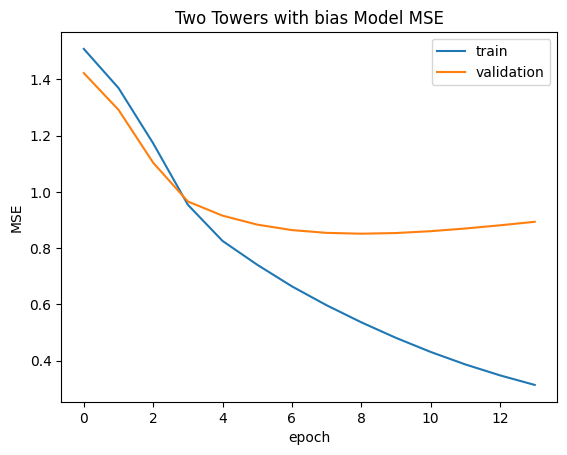



Erreur MSE méthode Two Tower : 0.8514
Erreur MAE methode Two Tower : 0.7341


In [37]:
#Affichez les résultats
plot_history(history_TwoTowers_bias, model_name="Two Towers with bias")

## Approche Auto Encodeur

### 3.1 Prétraitement et Formattage des données
Notre objectif est de présenter nos données à notre modèle de la manière suivante :<br>

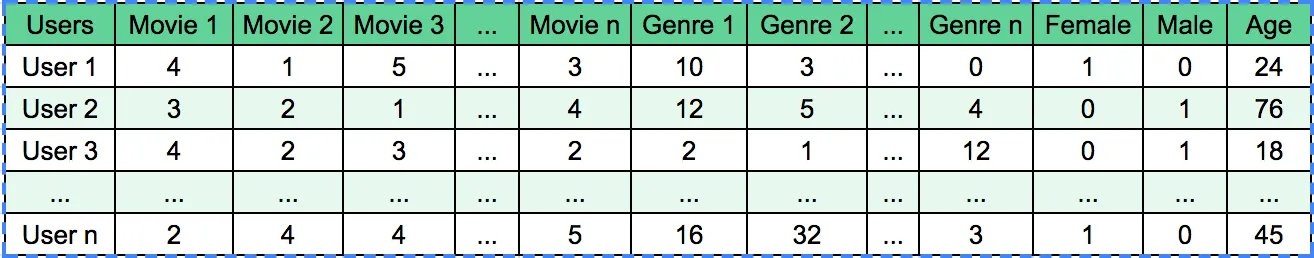

En effet, les données doivent représenter sous la forme d'un tableau à deux dimensions où chaque ligne représente un utilisateur. Les colonnes sont divisées selon les catégories suivantes :

-	Les n premières colonnes se rapportent à n films pour lesquels un utilisateur a attribué une note. Si l'utilisateur n'a pas évalué le film, la colonne contiendra la valeur 0
-	Les n colonnes suivantes représentent le nombre de genres. Nous élaborons ici une recommandation de films que l'utilisateur est susceptible de regarder. Par conséquent, la cellule correspondant à l'utilisateur 1 et au genre 1 représente le nombre de films que l'utilisateur 1 a évalués à plus de 3 ou plus pour la catégorie du genre 1. Il existe de nombreux types de règles que nous pouvons appliquer, mais cette règle pour a été choisie pour déterminer le goût de l'utilisateur pour un genre particulier.
-	Les dernières lignes indiquent les attributs de l'utilisateur, tels que son sexe, son âge et son métier.

In [ ]:
job_mapper = {job:i for i, job in enumerate(user_feat[' job '].unique())}

user_feat_p = user_feat.copy()
user_feat_p['female_user'] = (user_feat[' gender '] == 'F').astype(int)
user_feat_p['male_user']   = (user_feat[' gender '] == 'M').astype(int)
user_feat_p['job']         = user_feat[' job '].apply(lambda x: job_mapper[x])
user_feat_p.drop(columns=[' job ', ' zip', ' gender '], inplace=True)
user_feat_p.head()

,id,age,female_user,male_user,job
0,1,24,0,1,0
1,2,53,1,0,1
2,3,23,0,1,2
3,4,24,0,1,0
4,5,33,1,0,1


In [ ]:
movie_feat_p = movie_feat.copy()
movie_feat_p.drop(columns = movie_feat_p.columns[1:5], inplace=True)
movie_feat_p.head()

,movie id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
NAFILL = 0

def AddAdditionalFeatures(matrix, df, movie_df, user_feat_ext_df=None, add_additional_data=True):
    if(type(user_feat_ext_df) == type(None)):
        three_or_above = df[df.user_rating >=3]

        user_genre = three_or_above.merge(movie_df, left_on=votes_df.columns[1], right_on=movie_df.columns[0])
        user_genre = user_genre[[user_genre.columns[0]] + list(user_genre.columns[5:])].groupby('user_id').sum()
        user_feat_ext_df = user_feat_p.merge(user_genre, left_on=user_feat_p.columns[0], right_on=user_genre.index)
        user_feat_ext_df.drop(columns=[user_genre.columns[0]], inplace=True)
    
    if(add_additional_data):
        matrix = matrix.merge(user_feat_ext_df, left_on=matrix.index, right_on=user_feat_ext_df.columns[0])
        matrix.drop(columns=[user_feat_ext_df.columns[0]], inplace=True)
    
    matrix.fillna(NAFILL, inplace=True)

    return matrix, user_feat_ext_df

In [ ]:
from sklearn.model_selection import train_test_split

test_split  = 0.1
valid_split = 0.1
votes_train_df, votes_test_df  = train_test_split(votes_df, test_size=test_split)
votes_train_df, votes_valid_df = train_test_split(votes_train_df, test_size=valid_split *  votes_df.shape[0] / votes_train_df.shape[0])

In [ ]:
train_mat = votes_train_df.pivot(votes_train_df.columns[0], votes_train_df.columns[1], votes_train_df.columns[2])
valid_mat = votes_valid_df.pivot(votes_train_df.columns[0], votes_train_df.columns[1], votes_train_df.columns[2])
test_mat  = votes_test_df.pivot(votes_train_df.columns[0], votes_train_df.columns[1], votes_train_df.columns[2])

col_list = list(set().union(train_mat.columns, valid_mat.columns, test_mat.columns))
col_list.sort()

train_mat = train_mat.reindex(columns=col_list, fill_value=np.nan)
valid_mat = valid_mat.reindex(columns=col_list, fill_value=np.nan)
test_mat  = test_mat.reindex(columns=col_list, fill_value=np.nan)

print(valid_mat.shape)
print(test_mat.shape)
train_mat.head()

(919, 1682)
(919, 1682)


<ipython-input-33-267463b026ce>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  train_mat = votes_train_df.pivot(votes_train_df.columns[0], votes_train_df.columns[1], votes_train_df.columns[2])
<ipython-input-33-267463b026ce>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  valid_mat = votes_valid_df.pivot(votes_train_df.columns[0], votes_train_df.columns[1], votes_train_df.columns[2])
<ipython-input-33-267463b026ce>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  test_mat  = votes_test_df.pivot(votes_train_df.columns[0], votes_train_df.columns[1], votes_train_df.columns[2])


movie_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1673.0,1674.0,1675.0,1676.0,1677.0,1678.0,1679.0,1680.0,1681.0,1682.0
user_id,,,,,,,,,,,,,,,,,,,,,
1.0,5.0,NaN,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
add_feats = True
train_mat, user_feat_ext_df = AddAdditionalFeatures(train_mat, votes_train_df, movie_feat_p, add_additional_data=add_feats)
# user_feat_ext_df = None
valid_mat, _ = AddAdditionalFeatures(valid_mat, votes_valid_df, movie_feat_p, user_feat_ext_df, add_additional_data=add_feats)
test_mat, _  = AddAdditionalFeatures(test_mat, votes_test_df, movie_feat_p, user_feat_ext_df, add_additional_data=add_feats)
test_mat.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,9,8,3,32,36,34,20,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,2,10,4,9,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,3,0,7,3,3,7,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,4,3,3,7,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,12,7,2,6,24,12,7,1


In [ ]:
train_mat.columns[1682:]

Index([' age ', 'female_user', 'male_user', 'job', ' Action ', ' Adventure ',
       ' Animation ', ' Children's ', ' Comedy ', ' Crime ', ' Documentary ',
       ' Drama ', ' Fantasy ', ' Film-Noir ', ' Horror ', ' Musical ',
       ' Mystery ', ' Romance ', ' Sci-Fi ', ' Thriller ', ' War ',
       ' Western'],
      dtype='object')

### 3.2 Définition du Modèle Autoencodeur (5pts)

L'architecture du modèle ressemble à ceci :<br>
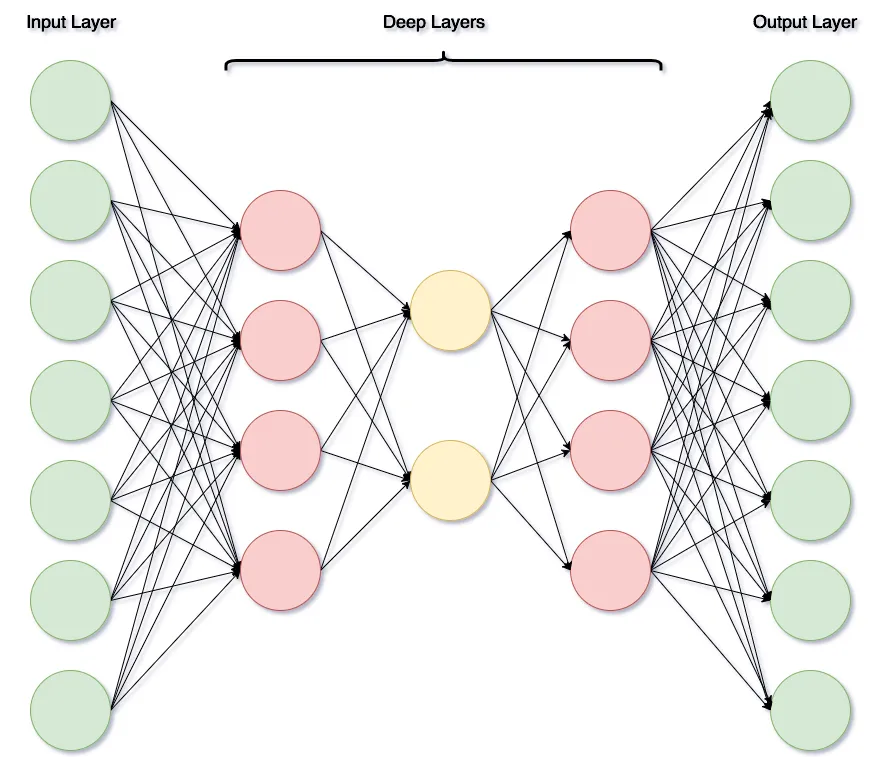

Notre réseau a **4 couches denses**, et pour nombre d'unités $[20, 10, 20, \text{output_length}]$ où `output_length` est la dimension de la sortie. Avant les trois premières couches denses, on s'attend à avoir un module `dropout` avec une probabilité `p`. <br>
Sur ce [lien](https://keras.io/api/layers/core_layers/dense/) vous aurez une bonne explication de ce que c'est une couche dense.

In [ ]:
from tensorflow.keras import layers, Sequential

class SAE(tf.keras.Model):
    def __init__(self, input_len, interval_pred_mode, output_len=None, min_vote=1, max_vote=5, p=0, name="MovieLensAutoEncoder", *args, **kwargs):
        super(SAE, self).__init__(*args, **kwargs)
        
        model = Sequential(name=name)

        model.add(tf.keras.Input(shape=(input_len,)))
        model.add(layers.Dropout(rate = p))
        model.add(layers.Dense(20, activation="sigmoid", name="DenseLayer1"))
        model.add(layers.Dropout(rate = p))
        model.add(layers.Dense(10, activation="sigmoid", name="DenseLayer2"))
        model.add(layers.Dropout(rate = p))
        model.add(layers.Dense(20, activation="sigmoid", name="DenseLayer3"))
        if(interval_pred_mode and output_len):
            model.add(layers.Dense(output_len, activation="sigmoid", name="DenseLayer4")) 
        else:
            model.add(layers.Dense(input_len, name="DenseLayer4"))

        self.model = model
        self.min_vote = min_vote
        self.max_vote = max_vote
        self.interval_pred_mode = interval_pred_mode

    def summary(self):
        self.model.summary()

    def call(self, x, training=None):
        if(self.interval_pred_mode):
            return self.model(x, training) * (self.max_vote-self.min_vote) + self.min_vote
        else:
            return self.model(x, training)

### 3.3 Définition de la Perte de notre Modèle (5 pts)
Nous ne pouvons pas exactement utiliser la perte standard puisque nous cherchons à prédire que les votes et non pas l'entièreté du vecteur d'entrée. Aussi, il ne faut pas prendre en compte les valeurs manquantes dans la perte.
- Codez une perte qui prend en compte ces deux informations !

In [ ]:
class ModifiedRootMeanSquarredError(tf.keras.losses.MeanSquaredError):
    def __init__(self, nb_movie, *args, **kwargs):
        super(ModifiedRootMeanSquarredError, self).__init__(*args, **kwargs)
        self.nb_movie = nb_movie

    def __call__(self, y_true, y_pred, sample_weight=None):
        y_true = y_true[:, :self.nb_movie]
        y_pred = y_pred[:, :self.nb_movie]
        return tf.math.sqrt(super(ModifiedRootMeanSquarredError, self).__call__(y_true[y_true > 0], y_pred[y_true > 0], sample_weight))

### 3.3 Entrainement du Modèle

In [ ]:
## Hyper Params
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

## Augment Data:
Augmentation = True
max_lambda   = 0.1

## Initializes datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_mat.to_numpy(), train_mat.to_numpy()))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_mat.to_numpy(), valid_mat.to_numpy()))
test_dataset  = tf.data.Dataset.from_tensor_slices((test_mat.to_numpy(), test_mat.to_numpy()))

if(Augmentation):
    copy = train_mat.copy()
    copy = copy.sample(frac=1).reset_index()
    copy.drop(columns=['index'],inplace=True)
    augmented_mat = train_mat + (train_mat - copy).apply(lambda row : np.random.uniform(low=0.0, high=max_lambda) * row)
    augmented_mat[augmented_mat < 1] = 0
    augmented_dataset = tf.data.Dataset.from_tensor_slices((augmented_mat.to_numpy(), augmented_mat.to_numpy()))
    train_dataset = train_dataset.concatenate(augmented_dataset)

In [ ]:
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE) 
test_dataset  = test_dataset.batch(BATCH_SIZE)

#### 3.3.1 Entrainez votre modèle en utilisant les hyper paramètres définis ci-dessous (10 pts). 
Notez qu'il faut **sauvegarder et tester le meilleure modèle sur l'ensemble de test**. Pour sauvegarder le meilleure modèle, vous pouvez utiliser `tf.keras.callbacks.ModelCheckpoint`.<br>
Je rappelle le lien ver la documentation de `keras.callbacks` [ici](https://keras.io/api/callbacks/).

In [ ]:
nb_films = len(votes_df['movie_id'].unique())

LR     = 0.005
Epochs = 15
p      = 0.5
interval_pred_mode = True
input_len  = train_mat.shape[1]
output_len = train_mat.shape[1] # train_mat.shape[1] or nb_films

#ToDo
my_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/checkpoint',
                  save_weights_only=True,
                  monitor='val_loss',
                  mode='max',
                  save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=5)]
sae = SAE(input_len, interval_pred_mode, output_len, p=p)
sae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=ModifiedRootMeanSquarredError(nb_films))
history_sae = sae.fit(train_dataset, epochs=Epochs, validation_data=valid_dataset, callbacks=my_callbacks)

Epoch 1/15
30/30 [==============================] - 4s 23ms/step - loss: 1.0960 - val_loss: 1.0536
Epoch 2/15
30/30 [==============================] - 0s 15ms/step - loss: 1.0320 - val_loss: 1.0313
Epoch 3/15
30/30 [==============================] - 0s 11ms/step - loss: 1.0280 - val_loss: 1.0347
Epoch 4/15
30/30 [==============================] - 0s 12ms/step - loss: 1.0280 - val_loss: 1.0330
Epoch 5/15
30/30 [==============================] - 0s 14ms/step - loss: 1.0283 - val_loss: 1.0339
Epoch 6/15
30/30 [==============================] - 0s 11ms/step - loss: 1.0255 - val_loss: 1.0329
Epoch 7/15
30/30 [==============================] - 0s 12ms/step - loss: 1.0260 - val_loss: 1.0323


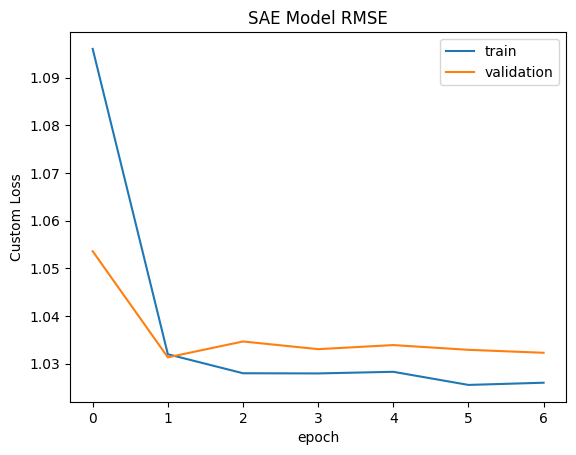



Best RMSE on validation : 1.0313


In [ ]:
plt.plot(history_sae.history['loss'])
plt.plot(history_sae.history['val_loss'])
plt.title('SAE Model RMSE')
plt.ylabel('Custom Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()
print("\n\nBest RMSE on validation : {0:.4f}".format(min(history_sae.history['val_loss'])))